In [1]:

import pandas as pd 
import os
from collections import Counter
import matplotlib.pyplot as plt


In [2]:

def get_ping_pong(trace):
    orgs = trace["org_group"].tolist()
    timestamps = trace["timestamp"].tolist()
    orgs = [(x, timestamps[i]) for i, x in enumerate(orgs) if i ==0 or x != orgs[i-1] ]
    pairs = []
    n = len(orgs)
    for ping_idx in range(n):
        ping_item = orgs[ping_idx][0]
        ping_timestamp = orgs[ping_idx][1]
        if ping_item in [x[0] for x in orgs[ping_idx:]]:
            for pong_idx in range(ping_idx+1, n):
                ping_again = orgs[pong_idx][0]
                if ping_item == ping_again:
                    duration_days = (orgs[pong_idx][1] - ping_timestamp).total_seconds() / (24*60*60)
                    pairs.append(((ping_item, orgs[pong_idx - 1][0]), (duration_days)))      
                    break
    return pairs

In [3]:

def ping_pong_trace_serie(trace):
    pairs = get_ping_pong(trace)
    return pd.Series({
        "case_seq_num": trace.name,
        "has_ping_pong": len(pairs) > 0,
        "ping_pong_pairs": pairs
    })


In [5]:

df = pd.read_pickle("../data/1_log_clean.pkl")
ping_pong_df = df.groupby("case_seq_num").apply(ping_pong_trace_serie).reset_index(drop=True)
ping_pong_df

C:\Users\antoi\AppData\Local\Temp\ipykernel_23436\3041458786.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ping_pong_df = df.groupby("case_seq_num").apply(ping_pong_trace_serie).reset_index(drop=True)


,case_seq_num,has_ping_pong,ping_pong_pairs
0,1-642402641,False,[]
1,1-642714990,True,"[((D6, V37 2nd), 6.938310185185185), ((V37 2nd..."
2,1-642761396,True,"[((D2, V37 2nd), 7.0859375), ((V37 2nd, V32 2n..."
3,1-642781041,False,[]
4,1-643338463,False,[]
...,...,...,...
7451,1-740862164,False,[]
7452,1-740865953,False,[]
7453,1-740865969,False,[]
7454,1-740866691,False,[]


In [6]:

num_ping_pong = ping_pong_df["has_ping_pong"].sum()
print(f"Number of traces with ping-pong: {num_ping_pong}")

Number of traces with ping-pong: 1201


In [7]:

all_pairs = [pair[0] for pairs in ping_pong_df["ping_pong_pairs"] for pair in pairs]
pair_counts  = Counter(all_pairs)
tt = sum(pair_counts.values())
print("Most common ping pong pairs")
for (a,b) , count in pair_counts.most_common(5):
    print(f"{a} <-> {b}: {count}/{tt} times, {(count / tt) * 100 :.2f}%")


Most common ping pong pairs
D5 <-> D4: 87/3026 times, 2.88%
D4 <-> N26 2nd: 63/3026 times, 2.08%
D7 <-> D4: 55/3026 times, 1.82%
D2 <-> D4: 47/3026 times, 1.55%
D4 <-> D5: 46/3026 times, 1.52%


In [9]:

all_orgs = []
all_orgs =[org for pair in all_pairs for org in pair]
orgs_counts  = Counter(all_orgs)
tt = sum(orgs_counts.values())
print("Most common ping pong org:groups")
for org , count in orgs_counts.most_common(5):
    print(f"{org}: {count}/{tt} traces, {(count / tt) * 100 :.2f}%")



Most common ping pong org:groups
D4: 650/6052 traces, 10.74%
G97: 427/6052 traces, 7.06%
D5: 299/6052 traces, 4.94%
D2: 204/6052 traces, 3.37%
D8: 187/6052 traces, 3.09%


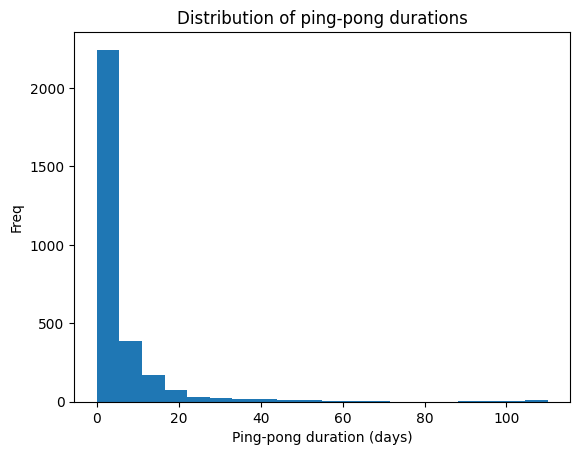

In [10]:

all_durations = [pair[1] for pairs in ping_pong_df["ping_pong_pairs"] for pair in pairs]

plt.hist(all_durations, bins=20)
plt.xlabel("Ping-pong duration (days)")
plt.ylabel("Freq")
plt.title("Distribution of ping-pong durations")
plt.show()


In [11]:

dd = pd.DataFrame(all_durations, columns=["duration"])
dd.describe()

,duration
count,3026.000000
mean,5.376455
std,11.406737
min,0.000243
25%,0.156881
50%,1.188814
75%,5.833333
max,110.123669


In [12]:

pair_df = pd.DataFrame(
    [
        (row.case_seq_num, p, d)
        for _, row in ping_pong_df.iterrows()
        for (p, d) in row.ping_pong_pairs
    ],
    columns=["case_seq_num", "pair", "duration"]
)
idx_max = pair_df.groupby("pair")["duration"].idxmax()
max_cases = (
    pair_df
    .loc[idx_max, ["case_seq_num", "pair", "duration"]]
    .sort_values("duration", ascending=False)
    .head(10)                       # top 10 pairs, change to .head(5) for top 5
    .reset_index(drop=True)
)

print("Top 5 ping pong pairs by max duration (with case):")
for _, row in max_cases.head(5).iterrows():
    a, b = row["pair"]
    print(f"Case {row['case_seq_num']}: {a} <-> {b} : {row['duration']:.2f} days")


Top 5 ping pong pairs by max duration (with case):
Case 1-647788578: D5 <-> V37 2nd : 110.12 days
Case 1-642714990: V37 2nd <-> V32 2nd : 109.03 days
Case 1-651196130: D6 <-> V46 2nd : 105.88 days
Case 1-655281402: G18 3rd <-> L23 3rd : 105.10 days
Case 1-652256138: D2 <-> V51 2nd : 103.88 days
